<a href="https://colab.research.google.com/github/mspatke/Deep-Learning-with-Tensorflow/blob/main/Saving_and_Loading__Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.8 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [5]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

In [6]:
#Part 1: Load dataset

(train_examples, validation_examples), info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised= True
)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
num_classes = info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in train_examples:
  num_training_examples += 1

for example in validation_examples:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [8]:
for i, example in enumerate(train_examples.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [9]:
def format_image(image, label):
  IMAGE_RES = 224
  #resize and normalized to range [0,1]

  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image,label

In [10]:
num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches = train_examples.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [11]:
#Part 2: Transfer Learning with tensorflow hub

#downloading mobilenet_v2
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

#first layer - defining the mobilenet model and passing the input size
feature_extracter = hub.KerasLayer(URL,
                                   input_shape = (IMAGE_RES, IMAGE_RES,3))

In [12]:
#freezing the variables in feature extracter layer
feature_extracter.trainable = False

In [13]:
model = tf.keras.Sequential([
  feature_extracter,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches )


Epoch 1/6
81/81 [==============================] - 18s 62ms/step - loss: 0.8370 - accuracy: 0.6898 - val_loss: 0.4854 - val_accuracy: 0.8411
Epoch 2/6
81/81 [==============================] - 4s 51ms/step - loss: 0.4061 - accuracy: 0.8634 - val_loss: 0.3688 - val_accuracy: 0.8719
Epoch 3/6
81/81 [==============================] - 4s 49ms/step - loss: 0.3190 - accuracy: 0.8961 - val_loss: 0.3337 - val_accuracy: 0.8865
Epoch 4/6
81/81 [==============================] - 4s 50ms/step - loss: 0.2661 - accuracy: 0.9202 - val_loss: 0.3150 - val_accuracy: 0.8919
Epoch 5/6
81/81 [==============================] - 4s 50ms/step - loss: 0.2266 - accuracy: 0.9346 - val_loss: 0.3034 - val_accuracy: 0.9037
Epoch 6/6
81/81 [==============================] - 5s 61ms/step - loss: 0.2025 - accuracy: 0.9439 - val_loss: 0.2987 - val_accuracy: 0.9019


In [15]:
#Check the predictions

class_names = np.array(info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [16]:
image_batch, label_batch = next(iter(train_batches.take(1)))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)

predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['dandelion', 'sunflowers', 'tulips', 'dandelion', 'dandelion',
       'tulips', 'dandelion', 'dandelion', 'dandelion', 'dandelion',
       'dandelion', 'sunflowers', 'daisy', 'daisy', 'sunflowers',
       'tulips', 'tulips', 'tulips', 'sunflowers', 'tulips', 'tulips',
       'roses', 'dandelion', 'daisy', 'dandelion', 'tulips', 'dandelion',
       'dandelion', 'tulips', 'roses', 'dandelion', 'dandelion'],
      dtype='<U10')

In [17]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 3 2 0 0 2 0 0 0 0 2 3 1 1 3 2 2 2 3 2 2 4 0 1 0 2 0 0 2 4 0 0]
Predicted labels:  [0 3 2 0 0 2 0 0 0 0 0 3 1 1 3 2 2 2 3 2 2 4 0 1 0 2 0 0 2 4 0 0]


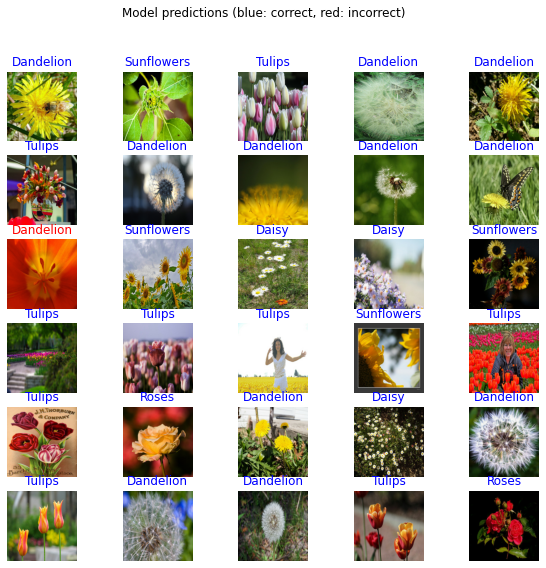

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [19]:
#Part 3: Save as Keras .h5 Model

#Saving the model as an HDF5 file

import time 

t = time.time()

export_path_keras = "./{}.h5.format(int(t))"
print(export_path_keras)

model.save(export_path_keras)

./{}.h5.format(int(t))
INFO:tensorflow:Assets written to: ./{}.h5.format(int(t))/assets


INFO:tensorflow:Assets written to: ./{}.h5.format(int(t))/assets


In [20]:
export_path_keras

'./{}.h5.format(int(t))'

In [21]:
!ls

'{}.h5.format(int(t))'	 sample_data


In [22]:
# load the saved Keras .h5 model

reloaded = tf.keras.models.load_model(
    export_path_keras,custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
#checking the result of reloaded model and previous model

result_batch = model.predict(image_batch)

reloaded_result_batch = reloaded.predict(image_batch)

In [24]:
#diffrence the output

(abs(result_batch - reloaded_result_batch).max())

0.0